In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score,  classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc,recall_score,precision_score, average_precision_score, mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler 

In [4]:
X=pd.read_csv('gamma.csv')
X['class'] = X['class'].replace(['h', 'g'], [0, 1])
y = X[['class']]
X = X.drop(['class'], axis=1)
X.head(5)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620


In [5]:
y.head(5)

,class
0,1
1,1
2,1
3,1
4,1


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13314, 10), (5706, 10), (13314, 1), (5706, 1))

In [7]:
y_train['class'].value_counts()

1    8627
0    4687
Name: class, dtype: int64

Najjednostavniji model - gama i C automatski

In [6]:
kernel = 'rbf'
model1 = Pipeline([('SVM', svm.SVC(kernel=kernel, probability=True, gamma='auto'))]) 
model1.fit(X_train, y_train['class'])
accuracy_test1 = model1.score(X_test, y_test['class'])
print("Accuracy: " + str(accuracy_test1))

Accuracy: 0.6584297230984928


In [10]:
def plot_roc_curve(fpr, tpr, auc_score):
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.754


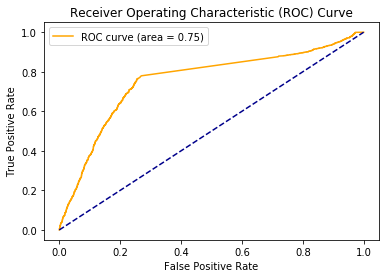

In [9]:
probs = model1.predict_proba(X_test)

probs = probs[:, 1]

auc = roc_auc_score(y_test['class'], probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test['class'], probs)

plot_roc_curve(fpr, tpr, auc) 

In [15]:
print("F1 score: ", end = "")
print(f1_score(y_test['class'], probs.round(), average = "macro"))
print("Precision: ", end = "")
print(precision_score(y_test['class'], probs.round(), average="macro"))
print("Recall: ", end = "")
print(recall_score(y_test['class'], probs.round(), average="macro"))

F1 score: 0.42289007645910953
Precision: 0.709021220903057
Recall: 0.5120636038256176


Grid search

In [16]:
pipeline = Pipeline([('SVM', svm.SVC(kernel='rbf',probability=True))])

parameters = {
    'SVM__C':(1.0,10.0,100.0,1000.0),
    'SVM__gamma':(0.001,0.01,0.1,1.0)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train['class'])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_) 
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['SVM']
parameters:
{'SVM__C': (1.0, 10.0, 100.0, 1000.0), 'SVM__gamma': (0.001, 0.01, 0.1, 1.0)}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 46.0min finished


done in 2976.823s

Best score: 0.868
Best parameters set:
	SVM__C: 1.0
	SVM__gamma: 0.001


In [8]:
kernel = 'rbf'
model2 = Pipeline([('SVM', svm.SVC(kernel=kernel, probability=True, gamma = 0.001, C = 1))]) 
model2.fit(X_train, y_train['class'])
accuracy_test2 = model2.score(X_test, y_test['class'])
print("Accuracy: " + str(accuracy_test2))

Accuracy: 0.8333333333333334


AUC: 0.873


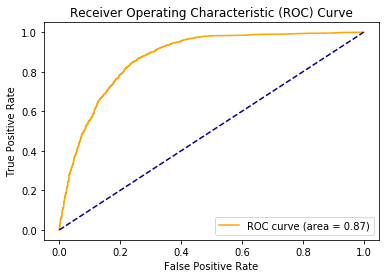

In [11]:
probs = model2.predict_proba(X_test)

probs = probs[:, 1]

auc = roc_auc_score(y_test['class'], probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test['class'], probs)
plot_roc_curve(fpr, tpr, auc)  

In [12]:
print("F1 score: ", end = "")
print(f1_score(y_test['class'], probs.round(), average = "macro"))
print("Precision: ", end = "")
print(precision_score(y_test['class'], probs.round(), average="macro"))
print("Recall: ", end = "")
print(recall_score(y_test['class'], probs.round(), average="macro"))

F1 score: 0.8075015117881442
Precision: 0.8265521646367971
Recall: 0.7963605241913456


Normalizacija

In [18]:
scaler = StandardScaler()  

scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)  
X_test_norm = scaler.transform(X_test)

X_train_norm, X_test_norm

(array([[-0.27269443, -0.41339656, -0.13204654, ..., -0.49812626,
          0.86994487, -1.23933553],
        [-0.69324657, -0.45297203, -1.01655052, ...,  0.22858557,
         -0.89852095,  0.56909058],
        [-0.78242468, -0.81324093, -1.46713892, ..., -0.27176112,
         -0.35744719, -1.51704886],
        ...,
        [-0.78709036, -0.55330851, -0.82660693, ...,  0.44548023,
         -0.56794811, -0.00632743],
        [-0.51749418,  0.057059  ,  0.22568055, ...,  0.91837548,
          1.99692134, -2.28319308],
        [-0.05938803, -0.63577378, -0.63877382, ..., -0.63879146,
          1.2226974 , -0.47944594]]),
 array([[-0.12577265, -0.60793226,  0.27443274, ..., -0.1178814 ,
         -0.02746224, -0.38882317],
        [-0.70477645, -1.21326002, -1.2404729 , ..., -0.00751405,
         -0.31717253,  0.54667638],
        [-0.30284227, -0.15358427,  1.07873831, ..., -0.34948818,
         -0.67131082,  0.01648703],
        ...,
        [-0.68785276, -0.66498581, -0.48386428, ...,  

In [21]:
kernel = 'rbf'
model3 = Pipeline([('SVM', svm.SVC(kernel=kernel, probability=True, gamma = 'auto'))]) 
model3.fit(X_train_norm, y_train['class'])
accuracy_test3 = model3.score(X_test_norm, y_test['class'])
print("Accuracy: " + str(accuracy_test3))

Accuracy: 0.8671573781983877


AUC: 0.915


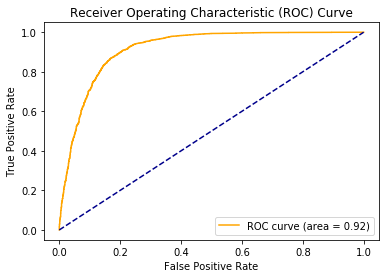

In [23]:
probs = model3.predict_proba(X_test_norm)

probs = probs[:, 1]

auc = roc_auc_score(y_test['class'], probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test['class'], probs)
plot_roc_curve(fpr, tpr, auc)  

In [24]:
print("F1 score: ", end = "")
print(f1_score(y_test['class'], probs.round(), average = "macro"))
print("Precision: ", end = "")
print(precision_score(y_test['class'], probs.round(), average="macro"))
print("Recall: ", end = "")
print(recall_score(y_test['class'], probs.round(), average="macro"))

F1 score: 0.8564836472688906
Precision: 0.8741133019622893
Recall: 0.8450481237114236


Grid search i normalizacija

In [25]:
pipeline = Pipeline([('SVM', svm.SVC(kernel='rbf',probability=True))])

parameters = {
    'SVM__C':(1.0,10.0,100.0,1000.0),
    'SVM__gamma':(0.001,0.01,0.1,1.0)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train_norm, y_train['class'])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_) 
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['SVM']
parameters:
{'SVM__C': (1.0, 10.0, 100.0, 1000.0), 'SVM__gamma': (0.001, 0.01, 0.1, 1.0)}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 24.6min finished


done in 1762.880s

Best score: 0.923
Best parameters set:
	SVM__C: 100.0
	SVM__gamma: 0.1


In [26]:
kernel = 'rbf'
model4 = Pipeline([('SVM', svm.SVC(kernel=kernel, probability=True, gamma = 0.1, C = 100))]) 
model4.fit(X_train_norm, y_train['class'])
accuracy_test4 = model4.score(X_test_norm, y_test['class'])
print("Accuracy: " + str(accuracy_test4))

Accuracy: 0.8787241500175255


AUC: 0.923


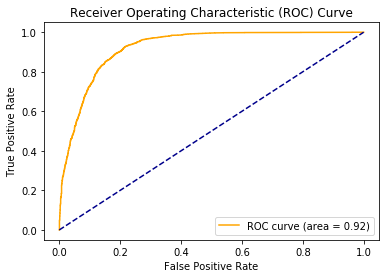

In [28]:
probs = model4.predict_proba(X_test_norm)

probs = probs[:, 1]

auc = roc_auc_score(y_test['class'], probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test['class'], probs)
plot_roc_curve(fpr, tpr, auc)  

In [29]:
print("F1 score: ", end = "")
print(f1_score(y_test['class'], probs.round(), average = "macro"))
print("Precision: ", end = "")
print(precision_score(y_test['class'], probs.round(), average="macro"))
print("Recall: ", end = "")
print(recall_score(y_test['class'], probs.round(), average="macro"))

F1 score: 0.8604931223958807
Precision: 0.8886012076126456
Recall: 0.8447496899323617
